In [1]:
import glob

files = glob.glob('/data/databases/OMA/OMA.2.1.1/data/*')
print files

['/data/databases/OMA/OMA.2.1.1/data/OmaServer.h5']


In [2]:

#add pyoma functions
import sys
sys.path.append('/home/USERNAME/pyoma')
import pyoma as po



In [3]:


omadata = '/data/databases/OMA/OMA.2.1.1/data/OmaServer.h5'
import tables as tb
import pandas as pd
import ete3 as ete3
import numpy as np
import pickle


In [4]:

#create a distmat for all species in the NCBI taxonomy
table = tb.open_file(omadata)


<h1> Build a Taxonomic Tree</h1>
The next cell takes the Taxonomy data in OMA and builds an ete3 tree object from it. We can use this object to select reference taxa for use in our co-evolution analysis.


In [5]:

#Add LUCA to start off the tree
t = ete3.Tree()
t.add_feature( 'SciName' , 'LUCA')
t.add_feature( 'ParentTaxonID' , 'None')
t.name = '0'

IdtoName={}
nameToID={}

IdtoName[0] = 'LUCA'
nameToID['LUCA']= str(0)
    


#cout of all nodes in the tree
nodes =1
    
print 'Building taxonomic tree'
for i,line in enumerate(table.root.Taxonomy):
    if i %1000 ==0:
        print i
    IdtoName[str(line[0])] = str(line[2])
    nameToID[str(line[2])]= str(line[0])
    
    child = t.search_nodes(name=str(line[1]))[0].add_child(name=str(line[0]) )
    child.add_feature( 'SciName' ,  line[2])
    child.add_feature( 'ParentTaxonID' , line[1])
    nodes +=1
print 'DONE'

handle1= open('./IdtoName.pkl','w')
handle2= open('./NameToID.pkl','w')

pickle.dump(IdtoName, handle1, -1)
pickle.dump(nameToID, handle2, -1)
handle1.close()
handle2.close()


Building taxonomic tree
0
1000
2000
3000
4000
DONE


In [6]:
#define a little wrapping function to allow the multiprocess library map function 
# to use the distance function from ete3

def get_dist(args):
    n,m = args
    return n.get_distance(m, topology_only = True)

#this is the distance matrix between all taxa
distmat = np.zeros((nodes, nodes ) ) 
column_dict = {}
print len(t)
print 'species'
print nodes
print 'taxonomic IDs'



2071
species
4167
taxonomic IDs


<h1> calculate the lower triangular distance matrix between all species in the tree </h1>
go through each node in the taxonomic tree and compute it's distance to all other nodes. Since m to n is the same distance as n to m we should only calculate the lower triangular matrix and add it to it's transvers to construct the final distance matrix. These distance only reflect topological distance in the species tree and not an actual evolutionary/time distance but it's still useful for grouping species/ selecting taxa etc...

This is a pretty heavy calculation to run. Would just recommend loading the pickled matrix to play around with it.

In [7]:
from multiprocessing import Pool

maxjobs = 100000
jobs = []
coords=[]
IdtoRow = {}
RowtoId = {}

print 'Computing lower triangular distmat'
for i,n in enumerate(t.traverse()):
    IdtoRow[n.name] = i
    RowtoId[i] = n.name

    for j, m in enumerate(t.traverse()):
        if i < j :
            coords.append([i,j])
            jobs.append([n,m])      
            if len(jobs)> maxjobs:
                print i
                pool = Pool()
                results = pool.map_async(get_dist,jobs).get()
                for k, coord in enumerate(coords):
                    i,j = coord
                    distmat[i,j] = results[k]
                jobs =[]
                coords =[]
                pool.close()
#run the leftovers     
pool = Pool()
results = pool.map_async(get_dist,jobs).get()
pool.close()
for k, coord in enumerate(coords):
    i,j = coord
    distmat[i,j] = results[k]       
distmat = distmat + distmat.T
print 'DONE'


Computing lower triangular distmat
24
48
72
97
121
146
171
196
221
247
272
298
324
350
377
403
430
457
484
511
538
566
594
622
650
679
708
737
766
796
825
855
886
916
947
979
1010
1042
1074
1107
1140
1173
1206
1240
1275
1309
1345
1380
1417
1453
1490
1528
1566
1605
1644
1684
1725
1766
1808
1851
1895
1939
1984
2031
2078
2126
2176
2227
2279
2333
2388
2446
2505
2566
2630
2696
2766
2840
2917
3000
3089
3186
3294
3418
3566
3767
DONE


In [9]:
import pickle
handle1 = open( './distmat.pkl','w')
handle2 = open( './TAXIDtoColumn.pkl' , 'w')
handle3 = open( './ColumntoTAXID.pkl' , 'w')

pickle.dump(distmat,handle1, -1)
pickle.dump(IdtoRow,handle2 , -1)
pickle.dump(RowtoId,handle3 , -1)

handle1.close()
handle2.close()
handle3.close()





<h1> calculate the 2 low dimensionality projections of the distance between species -> 3d and 1d</h1>

We can represent taxa that are closely grouped as colors that are similar to make reading figures easier. We can also group columns/labels based on taxonomic distance. These groupings won't take the hierarchy of the taxonomic tree into account though... all levels will be mixed together without much order ie([genus species family genus species] instead of [family genus genus genus species species species] ).

In [10]:
handle1 = open( './distmat.pkl','r')
distmat = pickle.load(handle1)
handle1.close()

from sklearn.manifold import MDS 

#embed the species to 3d space
mdsobj = MDS(n_components=3, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=-2, random_state=0, dissimilarity= "precomputed")
embeddings3d = mdsobj.fit_transform(distmat)

#embed the species to 1d space
mdsobj = MDS(n_components=1, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=-2, random_state=0, dissimilarity="precomputed")
embeddings1d = mdsobj.fit_transform(distmat)

#save the matrices
handle1 = open( './embeddings3d.pkl' , 'w')
handle2 = open( './embeddings1d.pkl', 'w')
pickle.dump( embeddings3d,handle1 , -1 )
pickle.dump( embeddings1d,handle2 , -1 )
handle1.close()
handle2.close()



<h1>plot the low dimensional mapping of the species tree onto the color and column space<h1>
to play around with the Hog presence matrix it will be useful to define a color scheme for all of the species so that we can see if we're using taxonomically diverse or taxonomically homogenous datasets at a glance.

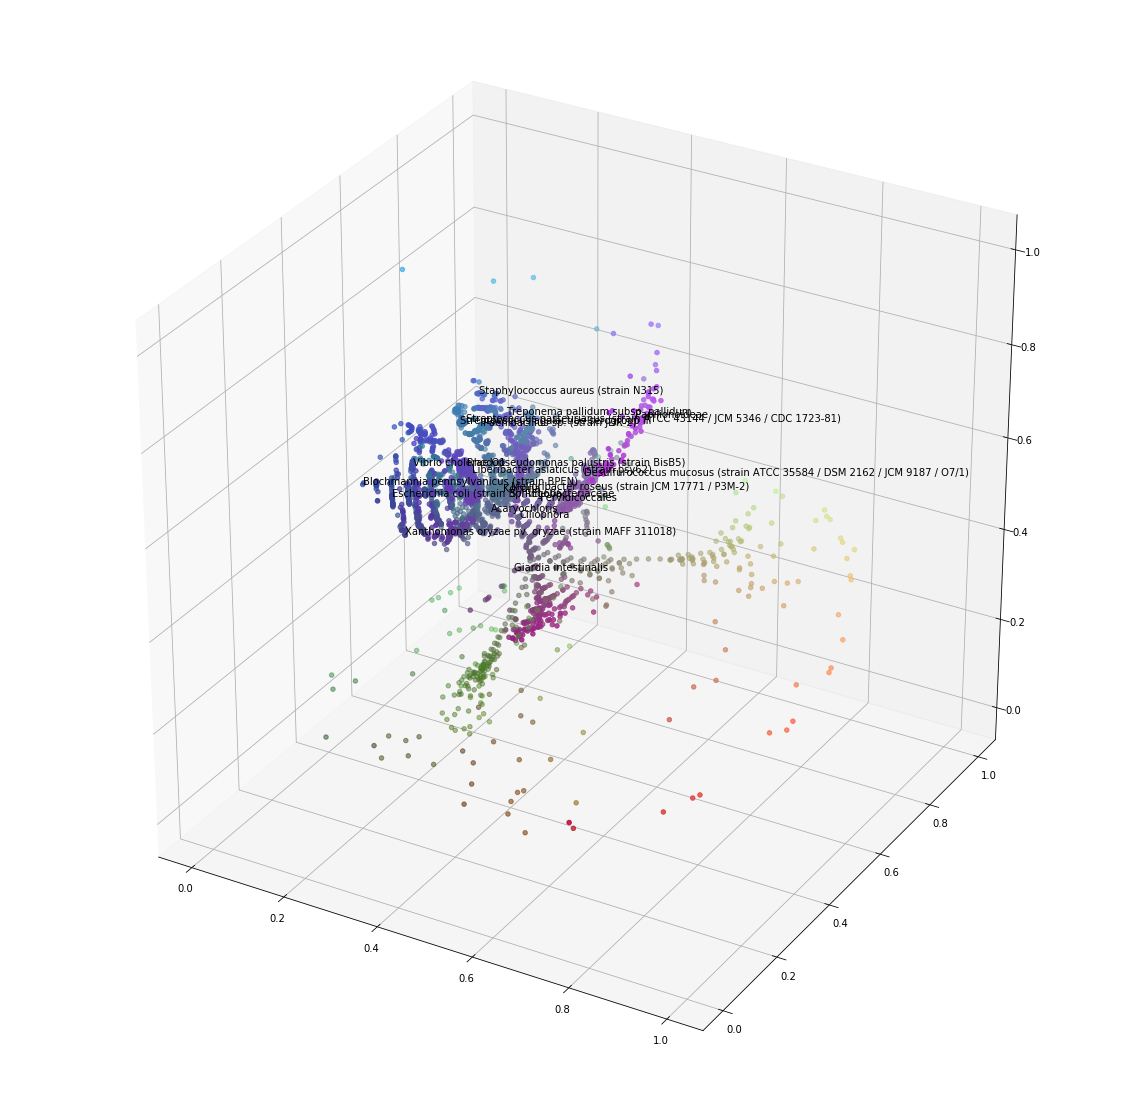

In [18]:
import numpy as np

from colour import Color
#create color and column mapping
def coord_to_color(coord):
    x,y,z= coord[0:3]
    c = Color(rgb=(x,y,z))
    return c.hex

import pickle
handle1 = open( './distmat.pkl','r')
handle3= open('./embeddings3d.pkl' , 'r')
handle4= open('./embeddings1d.pkl', 'r')


distmat = pickle.load(handle1)
embeddings3d = pickle.load(handle3)
embeddings1d = pickle.load(handle4)

handle1.close()
handle3.close()
handle4.close()


handle1= open('./IDtoName.pkl','r')
handle2= open('./NameToID.pkl','r')
NametoId = pickle.load(handle2)
IdtoName= pickle.load(handle1)
handle1.close()
handle2.close()


#transform the 3d embedding into a color scheme
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
embeddings3dScaled = scaler.fit_transform(embeddings3d)
colors = np.apply_along_axis( coord_to_color ,  1 , embeddings3dScaled)

#dictionary from TaxId to color
colorTaxaDict = dict(zip(column_dict.keys(),list(colors) ) ) 
TaxacolorDict = dict(zip( list(colors) , column_dict.keys() ))

handle1= open('./IDtoColor.pkl','w')
IdtoColor= pickle.dump(colorTaxaDict, handle1, -1)
handle1.close()

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

#plot species tree in 3d space w colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d' )
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
ax.scatter( embeddings3dScaled[:,0], embeddings3dScaled[:,1], embeddings3dScaled[:,2], color = colors  )

random_species = np.random.randint(0, len(IdtoRow)-1, 20)

#label a small random subset of taxa as a sanity check
def getspecies(input):
    return IdtoName[RowtoId[input]]

labels = np.vectorize(getspecies)(random_species)
coords = embeddings3dScaled[random_species , :]

for i,label in enumerate(labels):
    ax.text( coords[i,0] , coords[i,1] , coords[i,2], label , size = 10 , color = 'k' )
plt.show()




In [1]:

#reorder matrix columns based on 1d Mapping and save everything to use on the HOG data matrix

columns = np.argsort(embeddings1d, axis = 0)

columns = columns.flatten()
distmat = distmat[columns,:]
distmat = distmat[:, columns]

embeddings3d = embeddings3d[columns,:]

colors = colors[columns]

#maps taxID to a matrix column
column_dict=dict(zip( column_dict.keys(), list(columns)  ) )
column_dictReverse=dict(zip( list(columns) , column_dictReverse.values() ) )


handle1 = open( 'column_dictFinal.pkl' , 'w')
handle2 = open( 'column_dictReversFinal.pkl', 'w')




handle3 = open( 'colorsFinal.pkl', 'w')


pickle.dump(column_dict, handle1 , -1)
pickle.dump(column_dictReverse, handle2 , -1)
pickle.dump(colors, handle3 , -1)
handle1.close()
handle2.close()
handle3.close()


#check the column mappins and color scheme

plt.clf()
fig = plt.figure(figsize=(100, 100))
ax = fig.add_subplot(111 )

for i,column in enumerate(column_dictReverse.keys()[0:100]):
    try:
        ax.text( x=column%10 , y=int(column/10)  , s= IdtoName[column_dictReverse[column]] , color= colors[column] , rotation = 'vertical')
    except:
        print column

plt.show()
        



NameError: name 'np' is not defined